In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, log
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix,  classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import pickle

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# set default style
from matplotlib import rcParams
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10,4)})
rcParams['figure.figsize'] = 10,4

# Model Evaluation and Selection

## Model Training

In [4]:
# Importing the dataset
dataset = pd.read_csv('./data/Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]]
y = dataset.iloc[:, 4]

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [5]:
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Evaluation trough the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[64  4]
 [ 3 29]]


## Kfold

Training and testing are not enough to evaluate the performance, different test set has different variance

k-fold cross validation, k iteration to combine accuracy

In [6]:
# Applying k-Fold Cross Validation to generat 10 accuracies result
# use njobs-1 to use all cpu when using large dataset, to run faster
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

In [7]:
# find the mean of 10 accuracies
print(accuracies.mean())
print(accuracies.std())

0.9033333333333333
0.06574360974438671


## Grid Search

To find the best model and the best parameters. Normally, it is coded after classification model

Acuracy is the most common performance metric, it can be recall/precision 

In [8]:
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)

In [9]:
# the result of grid search and best parameters
print(grid_search.best_score_)
print( grid_search.best_params_)

0.9066666666666666
{'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}


In [10]:
grid_predictions = grid_search.predict(X_test)
print(grid_predictions)

[0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1
 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1]


In [11]:
accuracies = cross_val_score(estimator = grid_search, X = X_train, y = y_train, cv = 10)
print(accuracies.mean())
print(accuracies.std())

0.8966666666666667
0.0604611904907235


## Random Search

In [13]:
classifier.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [25]:
# Create the random grid
random_grid = {'C': [0.01, 0.1, 1, 5, 10, 20, 50, 100, 150, 200, 500, 1000],
               'kernel': ['linear', 'rbf'],
               'gamma': [round(x,2) for x in np.linspace(start = 0, stop = 1, num = 21)]}

In [26]:
# n_iter, cv control the number of combinations the number of folds to use for cross validation
svc_random = RandomizedSearchCV(estimator = classifier, 
                                param_distributions = random_grid, 
                                n_iter = 100, 
                                cv = 3, 
                                verbose=2, 
                                random_state=42, 
                                n_jobs = -1)
svc_random.fit(X_train, y_train)

print(svc_random.best_score_)
print( svc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    1.9s


0.9133333333333334
{'kernel': 'rbf', 'gamma': 0.65, 'C': 5}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.9s finished


In [27]:
svc_predictions = svc_random.predict(X_test)
accuracies = cross_val_score(estimator = svc_random, X = X_train, y = y_train, cv = 10)
print(accuracies.mean())
print(accuracies.std())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.5s


0.9033333333333333
0.062271805640898


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished


## Model Saving and Reading

In [15]:
# save model
with open('./model/svc_model.sav', 'wb') as sc:
       pickle.dump(classifier, sc)

In [18]:
# read model
with open('./model/svc_model.sav', 'rb') as sm:
    classifier = pickle.load(sm)
classifier

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

# Dimension Reduction

## Principle Components Analysis

As we've noticed before it is difficult to visualize high dimensional data, we can use PCA to find the first two principal components, and visualize the data in this new, two-dimensional space, with a single scatter-plot.

### PCA Example - 1

In [3]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(cancer['data'],columns=cancer['feature_names'])
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# feature scaling
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

In [5]:
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

In [6]:
# reduced 30 dimensions to just 2!
print(scaled_data.shape)
print(x_pca.shape)

(569, 30)
(569, 2)


Text(0, 0.5, 'Second Principal Component')

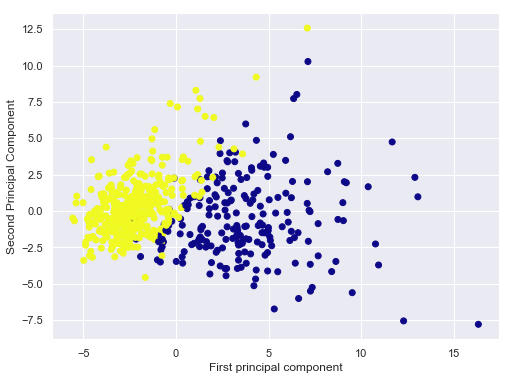

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=cancer['target'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [8]:
print(pca.components_[0].shape)
pca.components_[0]

(30,)


array([0.21890244, 0.10372458, 0.22753729, 0.22099499, 0.14258969,
       0.23928535, 0.25840048, 0.26085376, 0.13816696, 0.06436335,
       0.20597878, 0.01742803, 0.21132592, 0.20286964, 0.01453145,
       0.17039345, 0.15358979, 0.1834174 , 0.04249842, 0.10256832,
       0.22799663, 0.10446933, 0.23663968, 0.22487053, 0.12795256,
       0.21009588, 0.22876753, 0.25088597, 0.12290456, 0.13178394])

The components correspond to combinations of the original features, the components themselves are stored as an attribute of the fitted PCA object:

In this numpy matrix array, each row represents a principal component, and each column relates back to the original features. we can visualize this relationship with a heatmap:

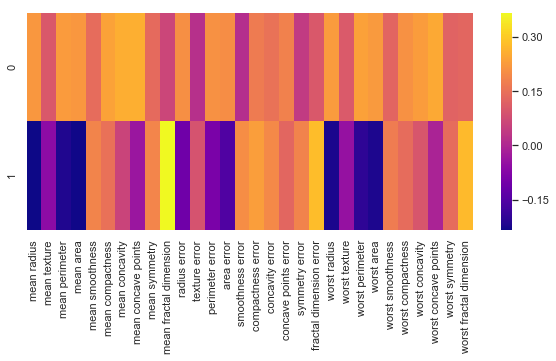

In [9]:
# higher number, closer to principal components
df_comp = pd.DataFrame(pca.components_,columns=cancer['feature_names'])
sns.heatmap(df_comp,cmap='plasma',)

### PCA Example - 2

In [10]:
# import data
dataset = pd.read_csv('./data/Wine.csv')
X = dataset.iloc[:, 0:13]
y = dataset.iloc[:, 13]

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
# Applying PCA before training model
# put n_components = None first too see all the cummulative variance
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.36884109 0.19318394]


Explained variance show the percentage of variance of each principle components

When n = None, 2 variables covered 56% of the variance 

Now, restart kernel, to change n_components = None to 2

In [12]:
# Fitting Logistic Regression to the Training set with only 2 variables that explained to most variant
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [13]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[14  0  0]
 [ 1 15  0]
 [ 0  0  6]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


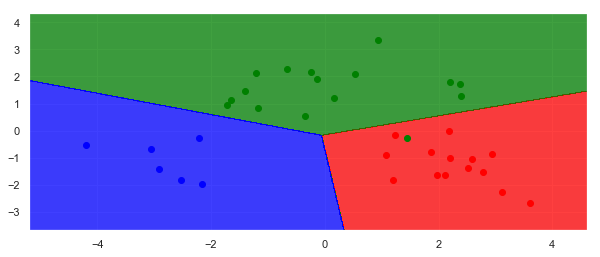

In [14]:
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)

### Kernel PCA

In [15]:
# import data
dataset = pd.read_csv('./data/Social_Network_Ads.csv')
x = dataset.iloc[:, [2,3]]
y = dataset.iloc[:, 4]

# split data
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.25, random_state=0)

#feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [16]:
# Apply kernel PCA and it changes the variables, and non linear variables will become linear
kpca = KernelPCA(n_components = 2, kernel = 'rbf')
X_train = kpca.fit_transform(X_train)
X_test = kpca.transform(X_test)

In [17]:
# fit
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, Y_train)
# predict
y_pred = classifier.predict(X_test)

In [18]:
confusion_matrix(Y_test, y_pred)

array([[64,  4],
       [ 6, 26]], dtype=int64)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


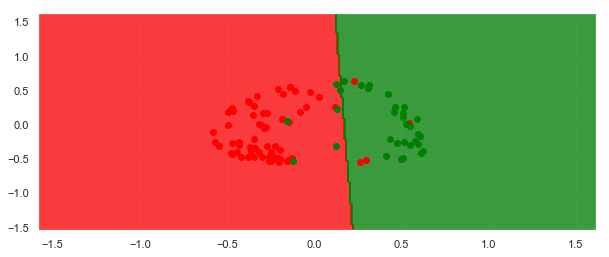

In [19]:
X_set, y_set = X_test, Y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)

## Linear Discriminant analysis

Quite similar to PCA, but interested in separating most of the classes of multiple variables

LDA is supervised because it is related to dependent variable

In [20]:
# import data
dataset = pd.read_csv('./data/Wine.csv')
X = dataset.iloc[:, 0:13]
y = dataset.iloc[:, 13]

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
# Applying LDA before training model, x left with 2 variables
lda = LinearDiscriminantAnalysis (n_components = 2)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [22]:
# fitting
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
# predict
y_pred = classifier.predict(X_test)

In [23]:
confusion_matrix(y_test, y_pred)

array([[14,  0,  0],
       [ 0, 16,  0],
       [ 0,  0,  6]], dtype=int64)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


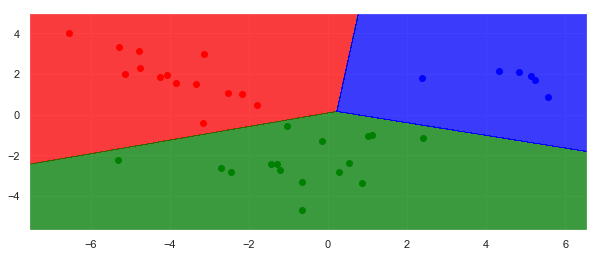

In [24]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)

# Recomender System

Basic recommendation system by suggesting items that are most similar to a particular item.

## Basic

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/u.data', sep='\t', names=column_names)
movie_titles = pd.read_csv("./data/Movie_Id_Titles")
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [3]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# find correlation
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

C:\Users\z0041yen\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\z0041yen\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [5]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


If we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

In [6]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [7]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [8]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


## Memory-Based Collaborative Filtering

Two most common types of recommender systems are **Content-Based** and **Collaborative Filtering (CF)**. 

* Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the "wisdom of the crowd" to recommend items. 
* Content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In general, Collaborative filtering (CF) is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective). The algorithm has the ability to do feature learning on its own, which means that it can start to learn for itself what features to use. 

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. 

In this tutorial, we will implement Model-Based CF by using singular value decomposition (SVD) and Memory-Based CF by computing cosine similarity. 

### Data Import

In [9]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/u.data', sep='\t', names=column_names)

movie_titles = pd.read_csv("./data/Movie_Id_Titles")

df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [10]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 944
Num of Movies: 1682


### Splitting and Predicting

Segment data into 2 sets

The training matrix contains 75% of the ratings and the testing matrix contains 25% of the ratings. 

In [11]:
train_data, test_data = train_test_split(df, test_size=0.25)

Memory-Based Collaborative Filtering approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**. 

A *user-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 

* *Item-Item Collaborative Filtering*: “Users who liked this item also liked …”
* *User-Item Collaborative Filtering*: “Users who are similar to you also liked …”

A distance metric commonly used in recommender systems is *cosine similarity*, where the ratings are seen as vectors in ``n``-dimensional space and the similarity is calculated based on the angle between these vectors. 
Cosine similiarity for users *a* and *m* can be calculated using the formula below, where you take dot product of  the user vector *$u_k$* and the user vector *$u_a$* and divide it by multiplication of the Euclidean lengths of the vectors.
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>

To calculate similarity between items *m* and *b* you use the formula:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>

Your first step will be to create the user-item matrix. Since you have both testing and training data you need to create two matrices.  

In [12]:
train_data.head()

,user_id,item_id,rating,timestamp,title
72307,235,747,2,889655550,Benny & Joon (1993)
87873,1,149,2,878542791,Jude (1996)
7633,467,327,4,879532164,Cop Land (1997)
63490,271,487,4,885848770,Roman Holiday (1953)
27771,928,48,5,880936817,Hoop Dreams (1994)


In [13]:
train_data_matrix = np.zeros((n_users, n_items))
train_data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [15]:
# Num of Users: 944
# Num of Movies: 1682

pd.DataFrame(train_data_matrix).tail()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
939,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
pd.DataFrame(test_data_matrix).tail()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
939,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# use the pairwise_distances function from sklearn to calculate the cosine similarity. 
# the output will range from 0 to 1 since the ratings are all positive.
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [18]:
pd.DataFrame(user_similarity).head()

,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
0,0.000000,0.810899,0.968692,0.962968,0.684885,0.629189,0.694464,0.720215,0.922003,0.725503,...,0.887446,0.825768,0.801752,0.841655,0.903888,0.736873,0.862677,0.834533,0.709138,0.908268
1,0.810899,0.000000,0.931484,0.904513,0.926442,0.834966,0.925111,0.937642,0.910175,0.855682,...,0.775183,0.755116,0.637540,0.753567,0.904715,0.815550,0.885311,0.852641,0.925782,1.000000
2,0.968692,0.931484,0.000000,0.756747,0.971478,0.926362,0.950487,0.928966,0.919100,0.927132,...,0.933015,0.892240,0.934513,0.955514,1.000000,0.866292,0.887626,0.942414,0.979252,1.000000
3,0.962968,0.904513,0.756747,0.000000,1.000000,0.970353,0.912596,0.912537,0.942733,0.961704,...,0.944680,0.923513,0.824229,0.910062,1.000000,0.821744,0.802016,0.907455,0.964016,1.000000
4,0.684885,0.926442,0.971478,1.000000,0.000000,0.794778,0.691620,0.774097,0.938812,0.837890,...,0.901487,0.952713,0.922952,0.900345,0.937511,0.731072,0.885417,0.882808,0.766873,0.870468


Next step is to make predictions. You have already created similarity matrices: `user_similarity` and `item_similarity` and therefore you can make a prediction by applying following formula for user-based CF:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

You can look at the similarity between users *k* and *a* as weights that are multiplied by the ratings of a similar user *a* (corrected for the average rating of that user). You will need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that you are trying to predict. 

The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. To give an example: suppose, user *k* gives 4 stars to his favourite movies and 3 stars to all other good movies. Suppose now that another user *t* rates movies that he/she likes with 5 stars, and the movies he/she fell asleep over with 3 stars. These two users could have a very similar taste but treat the rating system differently. 

When making a prediction for item-based CF you don't need to correct for users average rating since query user itself is used to do predictions.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

In [19]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

### Evaluation

There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is *Root Mean Squared Error (RMSE)*. 
<img src="https://latex.codecogs.com/gif.latex?RMSE&space;=\sqrt{\frac{1}{N}&space;\sum&space;(x_i&space;-\hat{x_i})^2}" title="RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}" />

You can use the [mean_square_error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE) function from `sklearn`, where the RMSE is just the square root of MSE. To read more about different evaluation metrics you can take a look at [this article](http://research.microsoft.com/pubs/115396/EvaluationMetrics.TR.pdf). 

In [43]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [44]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.117949279146394
Item-based CF RMSE: 3.446997306834411


Memory-based algorithms are easy to implement and produce reasonable prediction quality. 
The drawback of memory-based CF is that it doesn't scale to real-world scenarios and doesn't address the well-known cold-start problem, that is when new user or new item enters the system. 

Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don't have any ratings enter the system. Read [post](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/) about Memory-Based Collaborative Filtering. 

## Model-based Collaborative Filtering

Model-based Collaborative Filtering is based on **matrix factorization (MF)** which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. 

Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. 

When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the  user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

In [45]:
sparsity=round(1.0-len(df)/float(n_users*n_items),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 93.7%


Let's say for the MovieLens dataset you have the following information: _(user id, age, location, gender, movie id, director, actor, language, year, rating)_. 

By applying matrix factorization the model learns that important user features are _age group (under 10, 10-18, 18-30, 30-90)_, _location_ and _gender_, and for movie features it learns that _decade_, _director_ and _actor_ are most important. 

Now if you look into the information you have stored, there is no such feature as the _decade_, but the model can learn on its own. The important aspect is that the CF model only uses data (user_id, movie_id, rating) to learn the latent features. 

If there is little data available model-based CF model will predict poorly, since it will be more difficult to learn the latent features. 

Models that use both ratings and content features are called **Hybrid Recommender Systems** where both Collaborative Filtering and Content-based Models are combined. 

Hybrid recommender systems usually show higher accuracy than Collaborative Filtering or Content-based Models on their own: they are capable to address the cold-start problem better since if you don't have any ratings for a user or an item you could use the metadata from the user or item to make a prediction. 

### SVD
A well-known matrix factorization method is **Singular value decomposition (SVD)**. Collaborative Filtering can be formulated by approximating a matrix `X` by using singular value decomposition. The winning team at the Netflix Prize competition used SVD matrix factorization models to produce product recommendations, for more information I recommend to read articles: [Netflix Recommendations: Beyond the 5 stars](http://techblog.netflix.com/2012/04/netflix-recommendations-beyond-5-stars.html) and [Netflix Prize and SVD](http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf).
The general equation can be expressed as follows:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />


Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

Elements on the diagnoal in `S` are known as *singular values of `X`*. 


Matrix *`X`* can be factorized to *`U`*, *`S`* and *`V`*. The *`U`* matrix represents the feature vectors corresponding to the users in the hidden feature space and the *`V`* matrix represents the feature vectors corresponding to the items in the hidden feature space.

In [46]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 2.715073611668048


Carelessly addressing only the relatively few known entries is highly prone to overfitting. SVD can be very slow and computationally expensive. More recent work minimizes the squared error by applying alternating least square or stochastic gradient descent and uses regularization terms to prevent overfitting. Alternating least square and stochastic gradient descent methods for CF will be covered in the next tutorials.

Review:

* **Memory-based models** are based on similarity between items or users, where we use cosine-similarity.
* **Model-based CF** is based on matrix factorization where we use SVD to factorize the matrix.
* Building recommender systems that perform well in cold-start scenarios (where little data is available on new users and items) remains a challenge. The standard collaborative filtering method performs poorly is such settings. 

## Apriori

People bought ... also bought ... like ironman also like captain america

Calculation by finding support, confidence and lift

P (A|B)/P(A) to see how strong is the relation

In [48]:
dataset = pd.read_csv('./data/Market_Basket_Optimisation.csv', header=None)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
transactions = dataset.values.tolist()

In [63]:
# length decide the minimum item in basket
# can only experimental with different values for parameters
rules = apriori(transactions, min_support = 0.003, min_confidence = 0.2, min_lift = 3, min_length = 2)

## Reinforce Learning

Do it yourself, do it right will be rewarded

In [69]:
dataset = pd.read_csv('./data/Ads_CTR_Optimisation.csv')
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [70]:
# 10 ads with 10 000 rounds/users
N = 10000
d = dataset.shape[-1]
ads_selected = []
total_reward = 0

In [71]:
# create vector of size d containing 0
numbers_of_selections = np.zeros(d)
sums_of_rewards = np.zeros(d)

In [80]:
for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
        
            # average reward 
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            # confidence interval 
            delta_i = sqrt(3/2 * log(n + 1) / numbers_of_selections[i])
            
            # upper bound will be average + interval
            upper_bound = average_reward + delta_i
            
        else:
            upper_bound = 1e400
            
        # choose the max upper round in 10 ads
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i 
    ads_selected.append(ad)
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1
    reward = dataset.values[n, ad]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward
    total_reward = total_reward + reward

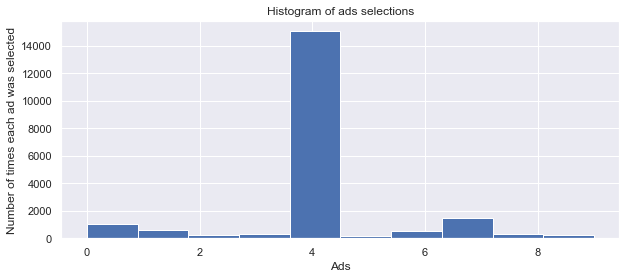

In [82]:
# Visualising the results
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

# Parametric Distribution Fitting

In [3]:
dataset = pd.read_csv('./data/Social_Network_Ads.csv')
dataset.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [4]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

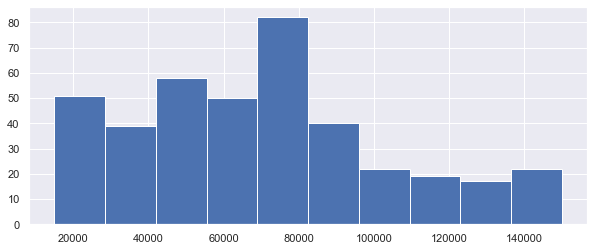

In [5]:
dataset['EstimatedSalary'].hist(bins=10)

In [6]:
best_dist, best_p, best_params = get_best_distribution(dataset['EstimatedSalary'])

p value for norm = 0.044834186921629944
p value for exponweib = 0.00019199863595852613
p value for weibull_max = 9.808412879486938e-305
p value for weibull_min = 8.055396547242545e-262
p value for pareto = 1.6716886766036144e-31
p value for genextreme = 2.569000248787886e-201
Best fitting distribution: norm
Best p value: 0.044834186921629944
Parameters for the best fit: (69742.5, 34054.3124104716)


In [17]:
# check cdf probabilities
st.norm.cdf(100000, 69742.5, 34054.3124104716)

0.8128659937347658

# Non-Parametric Fitting

In [18]:
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity

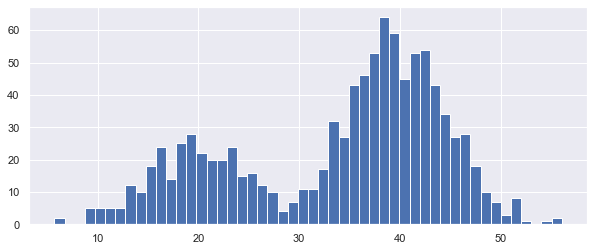

In [20]:
sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)
sample = hstack((sample1, sample2))
pyplot.hist(sample, bins=50)
pyplot.show()

In [21]:
# fit density
model = KernelDensity(bandwidth=2, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)

KernelDensity(algorithm='auto', atol=0, bandwidth=2, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [22]:
values = asarray([value for value in range(1, 60)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = exp(probabilities)

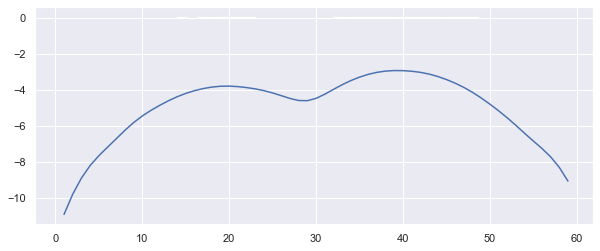

In [37]:
b(values[:], probabilities)
plt.hist(sample, bins=50, density=True)
plt.show()